In [81]:
#Importando os pacotes que vamos precisar para modelagem e comunicação com o Google Earth Engine
import ee
import geemap
import requests
import pandas as pd
import json
import time


In [82]:
# Comunicação com o Google Earth Engine
ee.Initialize()

In [83]:
# As duas entradas fornecidas pelo usuário - Geocódigo do município a ser estimado e a escala da redução.
# Para municípios com grande área territorial (Centro-Oeste, MATOPIBA), trabalhar com pelo menos 500m de escala

GEOCODE = '4104303'
Escala = 500;





In [84]:
# Obter os limites territorias do município direto da API de Malha Municipal do IBGE

url = f'http://servicodados.ibge.gov.br/api/v3/malhas/municipios/{GEOCODE}?formato=application/vnd.geo+json'
response = requests.get(url)
geo = response.json();
ee_object = geemap.geojson_to_ee(geo)
geometry = ee_object.geometry()

In [85]:
Map = geemap.Map(center=[-11.77,-45.76], zoom=8)

Map.addLayer(geometry, {}, "Geometria")

Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.

Map


Map(center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [86]:
#Se precisar especificar a geometria manualmente no mapa

#Map.draw_features
#roi = ee.FeatureCollection(Map.draw_features)
#geometry = roi.geometry()
#Map

In [87]:
#Função desenvolvida para fazer uma classificação não supervisionada a cada ano e pegar as 2 classes com maiores valor de EVI
# O objetivo é não precisar calculcar o EVI médio no município inteiro e sim nas classes com maior probabilidade de serem plantio.


def clusterization(image):

          
    # Load a pre-computed Landsat composite for input.
    input = image.clip(geometry).select("EVI");
  
    #Make the training dataset.
    training = input.sample(**{
    'region': geometry,
    'scale': Escala,
    'numPixels': 5000
    });

    #Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(5).train(training)
    #Cluster the input using the trained clusterer.
    result = input.cluster(clusterer)
 
    #Combine the mean and standard deviation reducers.
    reducers = ee.Reducer.mean()

    #Inicialização Lista de EVI dos clustes
    lista = ee.List([])

    #Iteração sobre os 5 Clusters para calcular a estatística de cada região
    for i in range(5):

        #Cálculo da geometria
        geom = result.select("cluster").eq(i).selfMask().reduceToVectors(**{
        'scale':Escala,
        });



        #Reducer para cálculo do EVI médio de cada cluster
        stats = image.reduceRegion(**{
        'reducer': reducers,
        'geometry':geom.geometry(),
        'scale':Escala,
        'bestEffort':True,
        'maxPixels':10000000000,
        });

        #Armarzena o EVI médio de cada clúster em uma lista
        lista = lista.add(stats.get("EVI"));


    #Cópia da Lista para ordenar os 2 maiores EVIs
    lista2 = lista;


    #Ordenar a lista para pegar os 2 maiores valores de EVI médio nos clusters
    #Agora nossos clustests de interesse estão nas posições 3 e 4 da lista 2
    lista2 = lista2.sort()

    #Pegar as chaves dos clusteres de interesse na lista original
    chaves1 = lista.indexOf(lista2.get(3))
    chaves2 = lista.indexOf(lista2.get(4))


    #Cálculo da Geometria final

    geom1 = result.select("cluster").eq(chaves1).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    geom2 = result.select("cluster").eq(chaves2).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    #Geom é a feature collection de nossos clusters de interesse
    geom = geom1.merge(geom2);



    stats = image.reduceRegion(**{
    'reducer': reducers,
    'geometry':geom.geometry(),
    'scale':Escala,
    'bestEffort':True,
    'maxPixels':10000000000,
    });


    return image.set('EVI_Cluster', stats.get("EVI"))
    



In [88]:
#Inicializando a lista que vai receber as informações de EVI médio do Google Earth Engine

stats = list();

In [89]:
#Dividir o processamento das imagens de acordo com o ano para não sobrecarregar o GEE

ano = list(range(2000, 2022))


    
for i in (ano):
    
    print ("Safra",i-1,"/",i)
    #Filtrar a territorialidade 
    #4 principais meses de safra - SOJA  NOV/FEV    
    mcollection = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i-1) + '-11-01', str(i-1) +'-12-31').filter(ee.Filter.calendarRange(11, 12,'month')).map(clusterization)
    mcollection2 = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i) + '-01-01', str(i) +'-02-28').filter(ee.Filter.calendarRange(1, 2,'month')).map(clusterization)    
    mcollection = mcollection.merge(mcollection2)
    
    #Pegar a propriedade que nos interessa em cada imagem - o EVI_Cluster Calculado 
    a = mcollection.aggregate_array('EVI_Cluster')
    
    
    #10s de soneca pra o GEE não derrubar as requests
    time.sleep(10)
    # Fazer a informação passar do servidor do google para o jupyter
    x = a.getInfo()
    #Salvar cada ano
    stats.append(x)    
    

Safra 1999 / 2000
Safra 2000 / 2001
Safra 2001 / 2002
Safra 2002 / 2003
Safra 2003 / 2004
Safra 2004 / 2005
Safra 2005 / 2006
Safra 2006 / 2007
Safra 2007 / 2008
Safra 2008 / 2009
Safra 2009 / 2010
Safra 2010 / 2011
Safra 2011 / 2012
Safra 2012 / 2013
Safra 2013 / 2014
Safra 2014 / 2015
Safra 2015 / 2016
Safra 2016 / 2017
Safra 2017 / 2018
Safra 2018 / 2019
Safra 2019 / 2020
Safra 2020 / 2021


In [90]:
#stats
#Visualizar o resutaldo

In [91]:
#Montando nosso Dataframe de EVIs
df = pd.DataFrame({'lin':stats})

#Renomeando as colunas
df = pd.DataFrame(stats, columns = ['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8'])

#Correção dos meses sem ponto
df.fillna(0)

#Visualização de nosso Dataframe de EVI
df

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,7368.085814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5108.407192,5417.432649,7459.640408,7365.725196,7376.908374,7590.082666,6694.451531,NaN
2,4916.746187,4919.562173,5341.226411,6878.484058,7425.690984,7628.427383,7839.268435,6775.023641
3,4577.517460,4909.304740,6228.071542,6959.448219,8285.299564,7953.630528,8083.732328,5559.841502
4,4735.472619,5040.572659,5753.646067,7763.334799,7574.875696,8043.415260,7293.794661,6751.289538
5,4824.639816,5363.046414,7472.834951,8648.726751,7417.304823,7746.385976,6503.200470,NaN
6,4467.997982,5479.181136,6163.026835,6777.912835,7315.513535,7981.531514,6866.344881,6215.066599
7,5383.415656,5446.824207,6357.599498,7839.044340,7765.149766,8016.690049,6605.301240,5196.690635
8,3785.245098,5016.989486,5670.458045,7173.851351,7851.579381,8684.423785,7505.126724,6574.824838
9,5254.575983,5178.582207,5368.412297,6907.177055,7873.320133,7397.906323,6687.792479,NaN


In [92]:
#Toda a parte de dados metereológicos já está rodando normalmente no modelo. Contudo, nessa modelagem não vamos utilizar 
# por conta da incosistência e indisponibilidade dos dados de estações do INMET para algumas regiões do país

#Identificação da Estação mais próxima
#url = f'https://apiprevmet3.inmet.gov.br/estacao/proxima/{GEOCODE}'
#response = requests.get(url).json()
#response

In [93]:
#Identificação do Código da estação
#estacao = response['dados']['CD_ESTACAO']

In [94]:
#Puxar dados históricos da estação identificada
#new_url = f'https://apitempo.inmet.gov.br/estacao/diaria/1999-11-01/2021-04-30/{estacao}'
#json_response = requests.get(new_url).json()
#dados_estacao = pd.DataFrame(json_response)
#dados_estacao

In [95]:
#Tratamento das datas
#dados_estacao['CHUVA'] = dados_estacao['CHUVA'].astype(float)
#dados_estacao['DT_MEDICAO'] = pd.to_datetime(dados_estacao['DT_MEDICAO'])
#dados_estacao['ANO'] = dados_estacao['DT_MEDICAO'].dt.year
#dados_estacao['MES'] = dados_estacao['DT_MEDICAO'].dt.month
#dados_estacao

In [96]:
#Correção dos dados omissos
#b  = dados_estacao.groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [97]:
#Construção da feature com os valores acumulados por mês durante a safra - NOV - ABR
#mask = (dados_estacao['MES'] <= 4) | (dados_estacao['MES'] >= 11)  
#b = dados_estacao.loc[mask].groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [98]:
#Construção do Dataframe com as features de pluviosidade
#chuva = b.values.reshape(22,6)
#df2 = pd.DataFrame(chuva, columns = ['C_NOV', 'C_DEZ','C_JAN','C_FEV','C_MAR','C_ABR'])
#df2

In [99]:
#Construção do Dataframe com as features de EVI e Pluviosidade
#concat_data = pd.concat([df,df2],axis=1).fillna(0)

In [100]:
#Visualização do Dataframe
#concat_data

In [101]:
#Request para obter os dados de rendimento histórico do SIDRA - IBGE

url3 = f'https://apisidra.ibge.gov.br/values/t/5457/n6/{GEOCODE}/v/112/p/last%2020/c782/40124'
json_response = requests.get(url3).json()
produtividade = pd.DataFrame(json_response)
Y = produtividade['V'].iloc[1:].values.ravel()
Y

array(['2695', '2985', '2987', '3137', '2733', '2280', '2677', '3099',
       '2984', '2407', '2982', '3400', '2496', '3293', '3221', '3574',
       '3048', '3840', '3600', '3000'], dtype=object)

In [102]:
#Transformar os dados em Dataframe
df3 = pd.DataFrame(Y)

In [103]:
#Importar os pacotes para treinamento dos modelos de regressão e série temporal
import sklearn
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [104]:

#Modelagem com os 3 maiores EVIS - Seleção das Features
df = df.fillna(0)
B = df.apply(lambda x: np.sort(x), axis=1, raw=True)
B


,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7368.085814
1,0.000000,5108.407192,5417.432649,6694.451531,7365.725196,7376.908374,7459.640408,7590.082666
2,4916.746187,4919.562173,5341.226411,6775.023641,6878.484058,7425.690984,7628.427383,7839.268435
3,4577.517460,4909.304740,5559.841502,6228.071542,6959.448219,7953.630528,8083.732328,8285.299564
4,4735.472619,5040.572659,5753.646067,6751.289538,7293.794661,7574.875696,7763.334799,8043.415260
5,0.000000,4824.639816,5363.046414,6503.200470,7417.304823,7472.834951,7746.385976,8648.726751
6,4467.997982,5479.181136,6163.026835,6215.066599,6777.912835,6866.344881,7315.513535,7981.531514
7,5196.690635,5383.415656,5446.824207,6357.599498,6605.301240,7765.149766,7839.044340,8016.690049
8,3785.245098,5016.989486,5670.458045,6574.824838,7173.851351,7505.126724,7851.579381,8684.423785
9,0.000000,5178.582207,5254.575983,5368.412297,6687.792479,6907.177055,7397.906323,7873.320133


In [105]:
#Train com dados do passado e Test com dados do futuro
Xtrain = B.iloc[1:19,4:9].fillna(0)
Xtest =  B.iloc[19:22,4:9].fillna(0)
Ytrain = Y[1:19]
Ytest = Y[19:20]

In [106]:
# Regressão Linear Simples
LR = LinearRegression()
# fitting the training data
LR.fit(Xtrain,Ytrain)
Y_LR =  LR.predict(Xtrain)

In [107]:
#Regressão Polinomial SVR

svr_poly = SVR(kernel='poly', C=1e3, degree=3)
Y_Poly = svr_poly.fit(Xtrain, Ytrain).predict(Xtrain)

In [108]:
#Regressão Ridge
reg = linear_model.Ridge(alpha=.5)
Y_Ridge = reg.fit(Xtrain, Ytrain).predict(Xtrain)

In [109]:
#Regressão Bayseana
regB = linear_model.BayesianRidge()
Y_Bay = regB.fit(Xtrain, Ytrain).predict(Xtrain)

In [110]:
# Teste de Acurácia das regressões
score=r2_score(Ytrain,Y_LR)
print("r2 Linear ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_LR))
score=r2_score(Ytrain,Y_Poly)
print("r2 Poly ",score)
print("mean_sqrd_error Polinomial ==",mean_squared_error(Ytrain,Y_Poly))
score=r2_score(Ytrain,Y_Ridge)
print("r2 Ridge ",score)
print("mean_sqrd_error Ridge ==",mean_squared_error(Ytrain,Y_Ridge))
score=r2_score(Ytrain,Y_Bay)
print("r2 Bayseano ",score)
print("mean_sqrd_error Bayseano ==",mean_squared_error(Ytrain,Y_Bay))


r2 Linear  0.4282033979932768
mean_sqrd_error Linear == 95001.70588337875
r2 Poly  -0.6066244155596556
mean_sqrd_error Polinomial == 266934.1854365532
r2 Ridge  0.42820339799297547
mean_sqrd_error Ridge == 95001.7058834288
r2 Bayseano  0.3053392095624089
mean_sqrd_error Bayseano == 115415.09667994051


In [111]:
#Previsão da Produtividade de 2019 a 2021
print("Produtividade em 2019:",Ytest)
print("Produtividade Reg Linear:",LR.predict(Xtest))
print("Produtividade Reg Polinomial:",svr_poly.predict(Xtest))
print("Produtividade Reg Ridge:",reg.predict(Xtest))
print("Produtividade Reg Bayeseana:",regB.predict(Xtest))

Produtividade em 2019: ['3000']
Produtividade Reg Linear: [2704.94280799 3353.97118124 3196.10934234]
Produtividade Reg Polinomial: [3096.47558027 5326.73127824 2905.13498288]
Produtividade Reg Ridge: [2704.94297889 3353.97115559 3196.10931952]
Produtividade Reg Bayeseana: [2872.65067774 3234.8452021  3108.82204218]


In [112]:
df = df.reset_index()
df

,index,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,0,7368.085814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,5108.407192,5417.432649,7459.640408,7365.725196,7376.908374,7590.082666,6694.451531,0.000000
2,2,4916.746187,4919.562173,5341.226411,6878.484058,7425.690984,7628.427383,7839.268435,6775.023641
3,3,4577.517460,4909.304740,6228.071542,6959.448219,8285.299564,7953.630528,8083.732328,5559.841502
4,4,4735.472619,5040.572659,5753.646067,7763.334799,7574.875696,8043.415260,7293.794661,6751.289538
5,5,4824.639816,5363.046414,7472.834951,8648.726751,7417.304823,7746.385976,6503.200470,0.000000
6,6,4467.997982,5479.181136,6163.026835,6777.912835,7315.513535,7981.531514,6866.344881,6215.066599
7,7,5383.415656,5446.824207,6357.599498,7839.044340,7765.149766,8016.690049,6605.301240,5196.690635
8,8,3785.245098,5016.989486,5670.458045,7173.851351,7851.579381,8684.423785,7505.126724,6574.824838
9,9,5254.575983,5178.582207,5368.412297,6907.177055,7873.320133,7397.906323,6687.792479,0.000000


In [113]:
#Parâmetros pra modelagem ARIMA

exog1 = B.iloc[1:20,6:9].fillna(0)
endog1 = df3[1:20]
arimax = sm.tsa.ARIMA(endog=endog1.astype(float),exog=exog1,order=(0,0,0)).fit()


C:\Users\Guga\miniconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [114]:
#Previsão de toda série temporal ARIMA
fcst = arimax.predict(start=0, end=19, dynamic=True, exog=exog1)
fcst

1     2962.257621
2     3026.377484
3     3291.732832
4     3075.593030
5     2811.638810
6     2660.655303
7     3160.935703
8     2900.462972
9     2785.858021
10    3034.484810
11    3295.290387
12    2694.937842
13    3444.087366
14    3156.031926
15    3565.737676
16    3018.293671
17    2850.396694
18    3258.872217
19    2749.355500
20    2962.257621
dtype: float64

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline



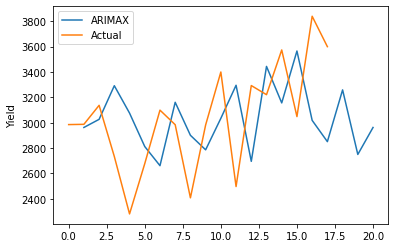

In [116]:
#Modelo ARIMA x Yield Real
Y_r = pd.Series(Ytrain).astype(float)

fcst.plot()
Y_r.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Yield');

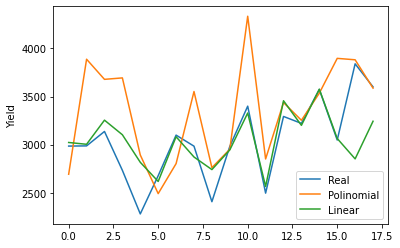

In [117]:
#Regressões x Yield Real
Y_r.plot()
pd.Series(Y_Poly).plot()
pd.Series(Y_LR).plot()
plt.legend(['Real','Polinomial', 'Linear'])
plt.ylabel('Yield');